In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from typing import List, Dict, Callable
from collections import defaultdict

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [2]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5)
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys()), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size,
    )

def tmap_dic_to_df(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            tmap_names.append(t.name)
            tmaps.append(np.zeros(len(tmap_dic)))
        break
        
    tmap = np.zeros(len(tmap_dic), dtype=np.float)
    for i, entry in enumerate(tmap_dic):
        sample_id.append(entry)
        for it, t in enumerate(tmap_dic[entry]):
            tmaps[it][i] = tmap_dic[entry][t]
    dd = {'sample_id' : sample_id}
    for name, tmap in zip(tmap_names, tmaps):
        dd[name] = tmap
    return pd.DataFrame(dd)

In [3]:
a = tmaps_with_properties_from_keys(
    '/home/erik/partners_ecg/hd5/2018-01', 
    {
        'partners_ecg_rate': lambda x: x > 0,
        'partners_ecg_pr': lambda x: x > 0,
        'partners_ecg_qt': lambda x: x > 0,
        'partners_ecg_qtc': lambda x: x > 0,        
        'partners_ecg_qrs': lambda x: x > 0
    },
    search_size = 20000
)
dd = tmap_dic_to_df(a)
dd

,sample_id,partners_ecg_rate,partners_ecg_pr,partners_ecg_qt,partners_ecg_qtc,partners_ecg_qrs
0,000007555-2018-01-09-09-25-57,52.0,202.0,450.0,418.0,108.0
1,000012814-2018-01-01-07-26-59,79.0,194.0,386.0,442.0,122.0
2,000012814-2018-01-01-18-11-40,82.0,168.0,388.0,453.0,124.0
3,000012814-2018-01-02-03-32-53,67.0,152.0,406.0,429.0,120.0
4,000012814-2018-01-02-04-04-47,61.0,202.0,434.0,436.0,124.0
...,...,...,...,...,...,...
11164,006279380-2018-01-30-11-52-34,140.0,138.0,286.0,436.0,72.0
11165,006279523-2018-01-27-13-25-48,119.0,126.0,296.0,416.0,78.0
11166,006279523-2018-01-27-15-30-56,128.0,128.0,294.0,429.0,82.0
11167,006279589-2018-01-30-19-22-23,69.0,168.0,358.0,383.0,90.0


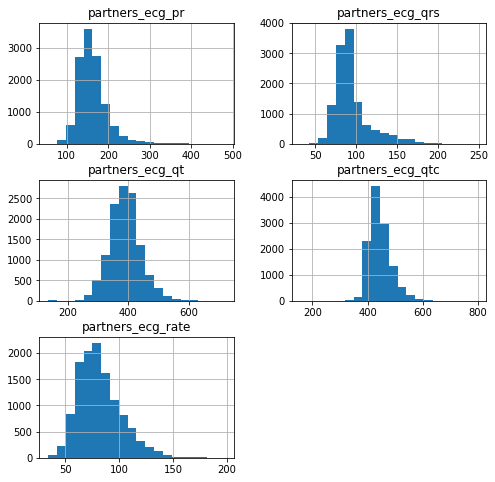

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = dd.hist(figsize=(8, 8), bins=20)
plt.savefig("/home/erik/histograms.png")

In [5]:
tmaps_by_sample_id(tensor_folder="/home/erik/partners_ecg/hd5/2019-01", sample_id: "006558841-2019-01-26-12-47-23.hd5", tmaps="partners_ecg_")

partners_ecg_rate     81.620467
partners_ecg_pr      161.040738
partners_ecg_qt      390.995792
partners_ecg_qtc     446.505327
partners_ecg_qrs      94.709106
dtype: float64

In [ ]:
dd.mean()

In [6]:
dd.std()

partners_ecg_rate    20.352292
partners_ecg_pr      35.003017
partners_ecg_qt      50.923113
partners_ecg_qtc     39.762255
partners_ecg_qrs     22.610711
dtype: float64

In [14]:
a = tmaps_with_properties_from_keys(
    '/home/erik/partners_ecg/hd5/2019-01', 
    {
        "partners_ecg_voltage": lambda x: True
#         'partners_ecg_rate': lambda x: x > 0,
#         'partners_ecg_pr': lambda x: x > 0,
#         'partners_ecg_qt': lambda x: x > 0,
#         'partners_ecg_qtc': lambda x: x > 0,        
#         'partners_ecg_qrs': lambda x: x > 0
    },
    search_size = 10
)

In [29]:
%matplotlib inline

def plot_ecg_from_tmap_dic(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    tmap_shapes = []
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            tmap_names.append(t.name)
            tmaps.append(np.zeros(len(tmap_dic)))
            tmap_shapes.append(t.shape)
        break
        
    for i, entry in enumerate(tmap_dic):
        sample_id.append(entry)
        for it, t in enumerate(tmap_dic[entry]):
            f, ax = plt.subplots(12, 1)
            f.set_size_inches(16,9)
            voltage = tmap_dic[entry][t]

            for lead in range(0, 12):
                ax[lead].plot(voltage[:, lead])
            
            f.savefig("/home/erik/ecg_voltage.png")
            break
        break

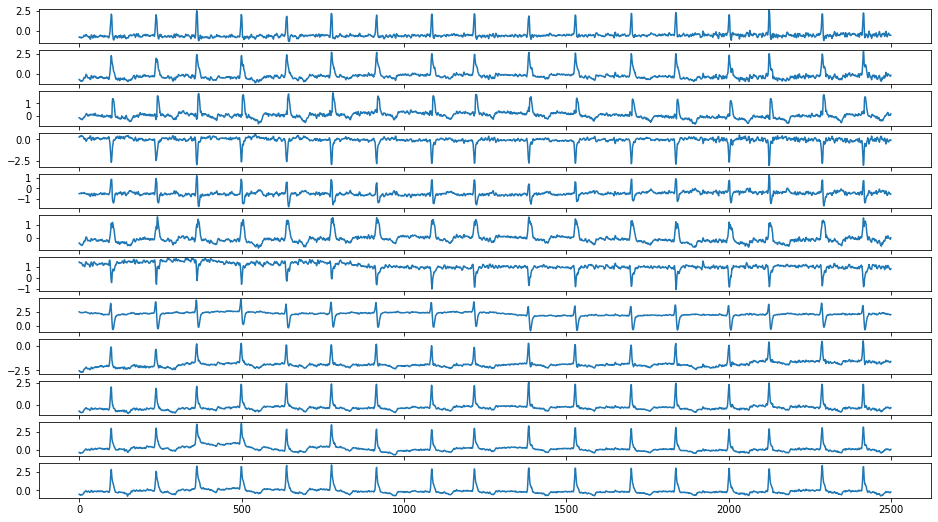

In [30]:
plot_ecg_from_tmap_dic(a)

In [8]:
dd.mean()

partners_ecg_rate     81.767950
partners_ecg_pr      160.828986
partners_ecg_qt      389.542857
partners_ecg_qtc     444.987909
partners_ecg_qrs      93.935404
dtype: float64

In [9]:
dd.std()

partners_ecg_rate    20.343338
partners_ecg_pr      35.506205
partners_ecg_qt      52.292443
partners_ecg_qtc     40.487247
partners_ecg_qrs     22.371607
dtype: float64